<b >This quickstart guide will walk you through: </b>
- Building a data <font color='seagreen'><b>reader</b></font>
- Building a <font color='seagreen'><b>producer</b></font> from the reader
- <font color='seagreen'><b>Filtering</b></font> the data in the producer
- Computing the <font color='seagreen'><b>Power Spectral Density (PSD)</b></font> of the filtered data

In [1]:
import time
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from openseize import demos
from openseize import producer
from openseize.io import edf
from openseize.filtering import fir
from openseize.spectra import estimators

## Locate Demonstration Data

The Openseize package has an accompanying demonstration data set in the European Data Format (EDF). This demo data is stored at Zenodo. Openseize will download it if its not in your local demo data directory.

In [2]:
# Get access to the file's path locally, downloading if needed
filepath = demos.paths.locate('recording_001.edf')

## Build a Reader

In [3]:
# Build a reader that will read all 4 channels in the EDF DATA
reader = edf.Reader(filepath)

In [4]:
# Show the metadata information for this reader instance
print(reader)

Reader Object
---Attributes & Properties---
{'path': PosixPath('/home/matt/python/nri/openseize/src/openseize/demos/data/recording_001.edf'),
 'header': {'version': '0',
            'patient': 'PIN-42 M 11-MAR-1952 Animal',
            'recording': 'Startdate 15-AUG-2020 X X X',
            'start_date': '15.08.20',
            'start_time': '09.59.15',
            'header_bytes': 1536,
            'reserved_0': 'EDF+C',
            'num_records': 3775,
            'record_duration': 1.0,
            'num_signals': 5,
            'names': ['EEG EEG_1_SA-B', 'EEG EEG_2_SA-B', 'EEG EEG_3_SA-B',
                      'EEG EEG_4_SA-B', 'EDF Annotations'],
            'transducers': ['8401 HS:15279', '8401 HS:15279', '8401 HS:15279',
                            '8401 HS:15279', ''],
            'physical_dim': ['uV', 'uV', 'uV', 'uV', ''],
            'physical_min': [-8144.31, -8144.31, -8144.31, -8144.31, -1.0],
            'physical_max': [8144.319, 8144.319, 8144.319, 8144.319, 1.0],
  

## Build a producer

The data has 4 channels and 18875000 samples. Lets build a producer iterable that will yield 4 x 100000 sized subarrays from this reader.

In [5]:
# build a producer that will produce 4 x 100e3 samples
# using the last axis as the sample axis
pro = producer(reader, chunksize=100e3, axis=-1)

## Lowpass filter the producer

Notice that the EDF reader contains 1 second duration records and each record contains 5000 samples so the sampling rate is 5 KHz. For our PSD we will only be interested in low frequencies (< 200 Hz) so we will low pass filter the producer. This will give us a new producer that produces 4 x 100e3 <b>filtered</b> samples.

In [6]:
# build a Finite Impulse Response filter to filter the 5 KHz data to 200 Hz. 
# The gpass is the acceptable ripple in the pass band in dB and the gstop is
# the minimum attenuation in the  stop band. The transition band will 30 Hz wide 
filt = fir.Kaiser(fpass=200, fstop=230, fs=5000, gpass=1, gstop=40)

It is always a good idea to check your filters response. Filters in openseize have a plot method that will show you the:
- Impulse Response
- Filters Gain in dB (blue) and phase response (orange)
- Unscaled Gain

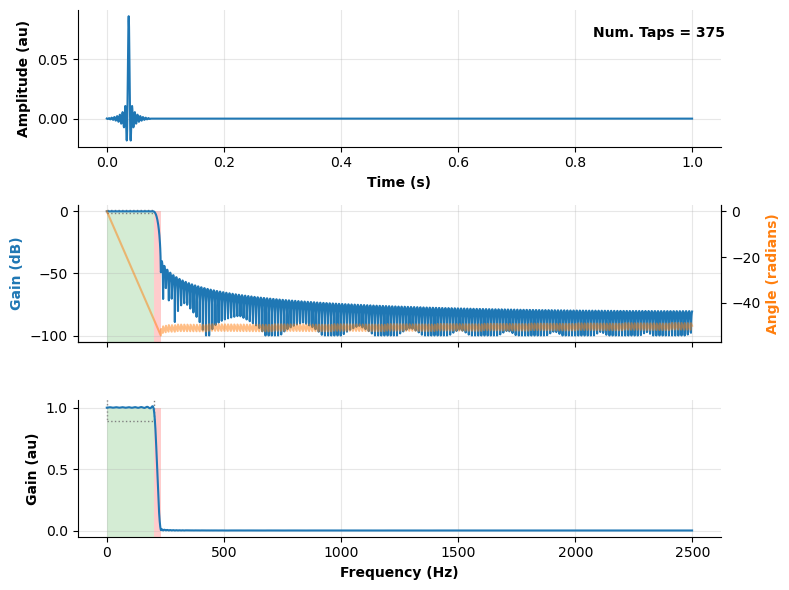

In [7]:
# check the filters response
filt.plot()

In [8]:
# apply the filter to the producer using 100e3 elements from each channel
# this makes a new producer! The 'same' mode adjust for the filters delay. 
filtpro = filt(pro, chunksize=100e3, axis=-1, mode='same')

## Compute the Power Spectral Density (PSD)

We have a filtering producer which yields 4 x 100e3 element arrays of filtered data. We will now compute the PSD of each channel in this filtering producer. <b>It is a good idea to open your system monitor to watch the memory consumption.</b> Openseize's PSD operation will request and process only a single array from the filtering producer at any one time. Thus <b>the max memory consumption will be a single filtered array.</b> If you use Scipy, all the data (4, 18875000) will have to be loaded, then filtered and stored before the PSD is computed. This is the power of iterative computation in Openseize.

In [9]:
t0 = time.perf_counter()
cnt, freqs, results = estimators.psd(filtpro, fs=5000, axis=-1, resolution=0.5)
elapsed = time.perf_counter() - t0

msg = 'PSD computed on producer of shape ({}, {}) in {} secs'
print(msg.format(*filtpro.shape, elapsed))

PSD computed on producer of shape (4, 18875000) in 7.581253411000944 secs


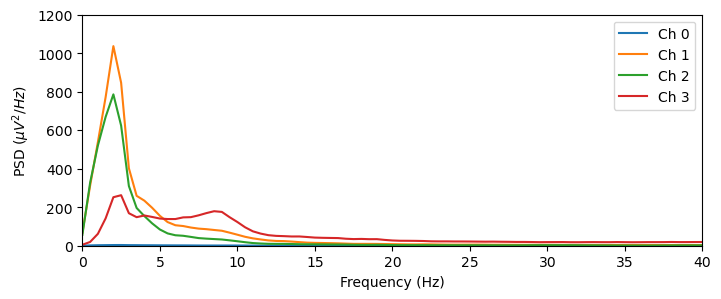

In [10]:
fig, ax = plt.subplots(figsize=(8,3))
for ch, arr in enumerate(results):
    
    ax.plot(freqs, arr, label='Ch {}'.format(ch))
    ax.legend()
    ax.set_xlim([0,40])
    ax.set_ylim(0, 1200)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(r'PSD ($\mu V^2 / Hz$)')

plt.show()

<b>Openseize is an expanding ecosystem of iterative Digital Signal Processing (DSP) tools. Currently it supports the following I/O and DSP processes:</b>

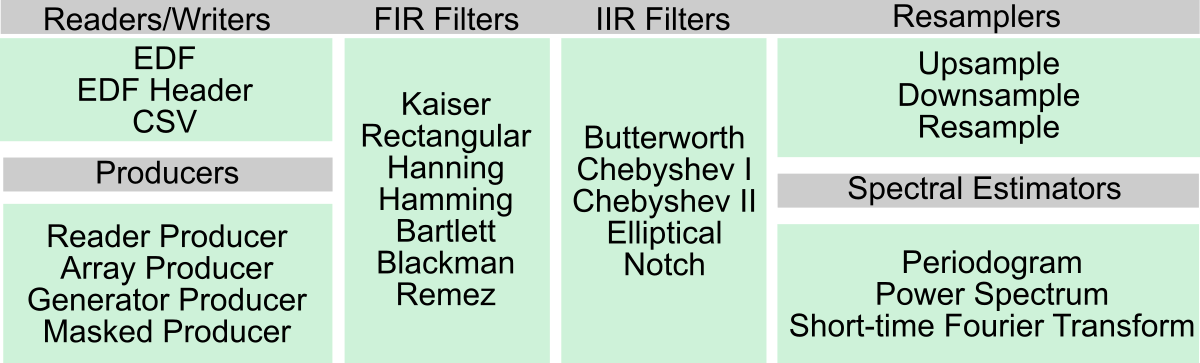

In [11]:
Image(filename=Path.joinpath(Path.cwd(), "imgs/types.png"))